# Introduction

An accurate and robust traffic flow prediction is fundamental to Intelligent Transportation Systems (ITS) applications aiming to mitigate traffic congestion. In this notebook, we focus on short-term traffic flow prediction which is important for managing the existing facilities, especially during peak-hours. Roadway facilities are most vulnerable when demand is likely to exceed exisitng capacity. Therefore, if we know in advance the anticipated traffic volume, we can put in place approproate traffic management measures. 

We use the I-94 traffic dataset (https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) that contains hourly traffic volumes along with weather and temperature information. Next, we explore the dataset to predict traffic volumes for the next hour.

The problem can be framed as:

$$
q_{t} = f(q_{t-1}, w_{t-1}, s_{t-1})
$$

where $q_{t}$ refers to traffic volume for the time step $t$, $q_{t-1}$ refers to traffic volume for the time step $t-1$, $w_{t-1}$ refers to weather and temperature conditions for the time step $t-1$, and $s_{t-1}$ refers to the seasonal effects for the time step $t-1$. Seasonal effects can be attributed to temporal characteristics such as years, months, days of a week, and hours of a day. 

# Exploring I-94 traffic data

First, we will load the dataset.

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=Warning)

df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

The Interstate Traffic Volume Dataset contains information about the hourly traffic volume on the West-bound lane of Interstate-94 (I-94) from MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN in the US. The dataset also includes hourly weather and temperature reports from 2012 to 2018. The dataset includes the following 9 fields.

| Field               | Description                                                      | Data type   |
|:--------------------|:-----------------------------------------------------------------|:------------|
| holiday             | US National holidays plus regional holiday, Minnesota State Fair | Categorical |
| temp                | Average temp in kelvin                                           | Numeric     |
| rain_1h             | Amount in mm of rain that occurred in the hour                   | Numeric     |
| snow_1h             | Amount in mm of snow that occurred in the hour                   | Numeric     |
| clouds_all          | Percentage of cloud cover                                        | Numeric     |
| weather_main        | Short textual description of the current weather                 | Categorical |
| weather_description | Longer textual description of the current weather                | Categorical |
| date_time           | Hour of the data collected in local CST time                     | Date time   |
| traffic_volume      | Hourly I-94 ATR 301 reported westbound traffic volume            | Numeric     |


Let's visualize 10 random rows present in the dataset to get a sense how data look like.

In [2]:
df.sample(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
28513,None,271.34,0.0,0.0,90,Mist,mist,2016-11-27 02:00:00,529
9040,None,294.15,0.0,0.0,75,Clouds,broken clouds,2013-09-19 13:00:00,5060
39540,None,264.30,0.0,0.0,5,Clear,sky is clear,2017-12-06 07:00:00,5255
21805,None,284.36,0.0,0.0,90,Rain,moderate rain,2016-03-15 08:00:00,5771
36735,None,291.64,0.0,0.0,40,Mist,mist,2017-08-29 10:00:00,4991
42746,None,272.89,0.0,0.0,1,Clear,sky is clear,2018-03-29 22:00:00,3691
37923,None,284.30,0.0,0.0,1,Clear,sky is clear,2017-10-10 16:00:00,6745
19964,None,277.01,0.0,0.0,90,Drizzle,drizzle,2015-12-13 04:00:00,289
40793,None,275.64,0.0,0.0,75,Clouds,broken clouds,2018-01-19 21:00:00,3370
13591,None,287.12,0.0,0.0,90,Clouds,overcast clouds,2014-04-11 20:00:00,3217


In [3]:
print('Total number of observations:', df.shape[0])

Total number of observations: 48204


Next, we will check if data contain any missing values!

In [4]:
df.isna().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

We observe that the dataset is complete. Now, we will check the data type of date_time field in the dataset.

In [5]:
print('The type of date_time field is:', df['date_time'].dtypes)

The type of date_time field is: object


It is useful to convert this field into a pandas datetime object so that we can process this field in a convenient manner.

In [6]:
df['date_time'] = pd.to_datetime(df['date_time']) 
print('The type of date_time field is:', df['date_time'].dtypes)

The type of date_time field is: datetime64[ns]


Now, we frame data for the short-term prediction purposes. We will now create two new columns that contain next hour datetime object and associated traffic volume that will be our target variable. After that, we will only keep rows that satisfy our requirements. Target varible corresponds to a time-step that is an hour later than the other variables present in the dataset.

In [7]:
df['traffic_volume_target'] = df['traffic_volume'].shift(-1)
df['date_time_target'] = df['date_time'].shift(-1)
df['time_diff'] = df['date_time_target'] - df['date_time']
df = df[df.time_diff.dt.seconds == 3600]
df = df.dropna()
df = df.drop(columns=['date_time'])

cols = [col for col in df if col != 'traffic_volume_target'] + ['traffic_volume_target']
df = df[cols]

Now we check if there are any missing days in the dataset for which data are not collected. It seems that there is a large gap in the dataset around 2015.

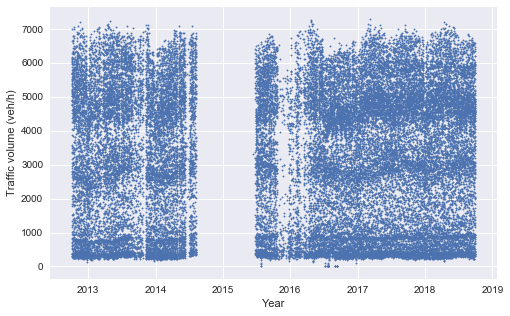

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn")

plt.figure(figsize=(8,5))
plt.scatter(df['date_time_target'], df['traffic_volume_target'], s = 2)
plt.xlabel('Year')
plt.ylabel('Traffic volume (veh/h)');

If we plot traffic counts per year, we observe that less data are collected for 2012, 2014, and 2015. For 2012, data collection has been started from the month of October. However, fewer entries for years 2014 and 2015 can be explained by missing data in the dataset. We have counts from each of the year present in the dataset though. 

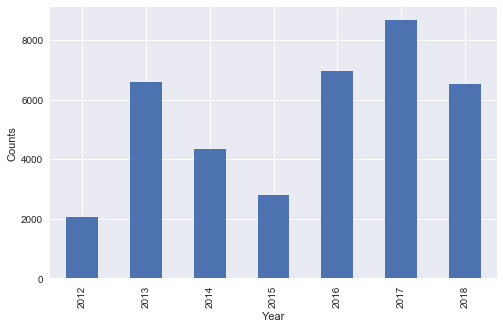

In [9]:
plt.figure(figsize=(8,5))
df['date_time_target'].dt.year.value_counts().sort_index().plot(kind='bar');
plt.xlabel('Year')
plt.ylabel('Counts');

## Numerical features

Now let's compare the numerical feature distributions for each label value.

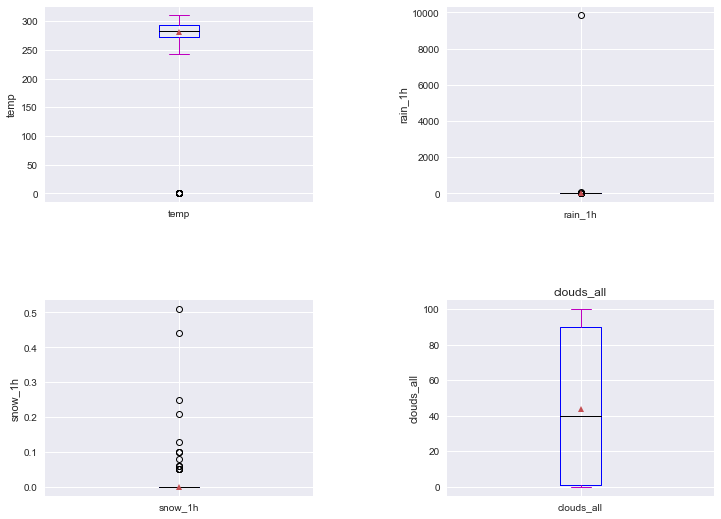

In [10]:
%matplotlib inline
figure, axes = plt.subplots(2, 2, figsize=(12,9))
plt.subplots_adjust(hspace = 0.5, wspace=0.50)

numeric_features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
i=0

for col in numeric_features:
    a = int(np.floor(i/2))
    b = i%2
    ax = df.boxplot(column=col, ax=axes[a][b],
              color=dict(boxes='blue', whiskers='m', medians='k', caps='m'),
             showfliers=True, grid=True, rot=0, showmeans = True)
    ax.set_ylabel(col)
    i=i+1
    plt.title(col)
plt.show()

Next, we use the Z-score based method to remove outliers from our dataset. Z-score can be computed as $Z = \frac{X- \mu}{\sigma}$. Here, $X$ refers to the data, $\mu$ refers to mean, and $\sigma$ refers to the standard deviation. A standard cut-off value for finding outliers are Z-scores of +/-3 or further from zero. 

In [11]:
from scipy import stats
df = df[(np.abs(stats.zscore(df[numeric_features])) < 3).all(axis=1)]

Next, we will check correlations.

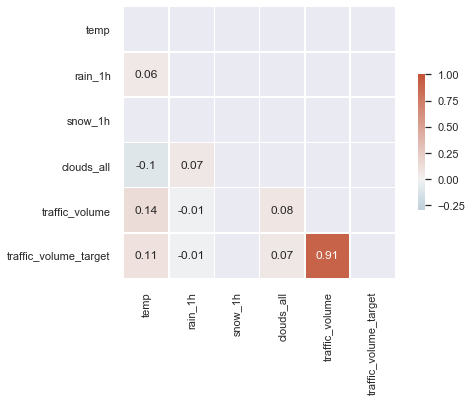

In [12]:
corr=df.corr(method ='pearson').round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(rc={'figure.figsize':(8,5)})

sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.3, vmax=1.0, center=0, annot = True, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

It seems that numerical features are weakly correlated with each other. Moreover, temperature and cloud cover are also weakly correlated with hourly traffic volume with values of 0.11 and 0.07, respectively. 

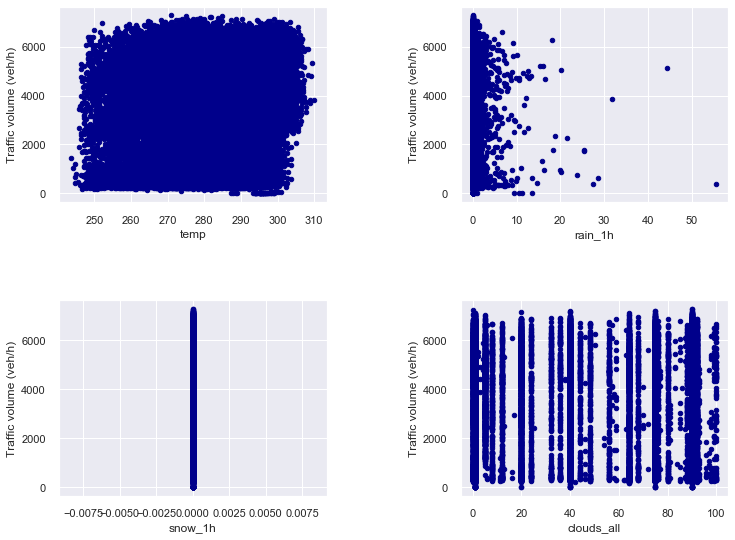

In [13]:
%matplotlib inline
figure, axes = plt.subplots(2, 2, figsize=(12,9))
plt.subplots_adjust(hspace = 0.5, wspace=0.50)

numeric_features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
i=0

for col in numeric_features:
    a = int(np.floor(i/2))
    b = i%2
    ax = df.plot.scatter(x=col, y = 'traffic_volume_target',ax=axes[a][b], c='DarkBlue')
    ax.set_xlabel(col)
    ax.set_ylabel('Traffic volume (veh/h)')
    i=i+1
plt.show()

The weak dependence of numeric features on the target variable is also captured by the above plots. We can remove snow_1h from features as it can no longer explain traffic volume. For other three numeric features, we can bin them into four discrete categories using a quantile based method. We first plot their distriutions and also quantiles.

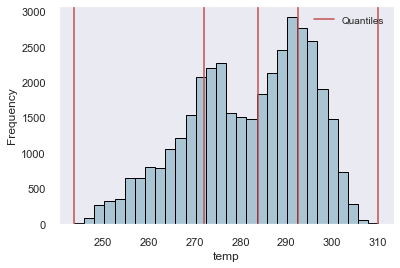

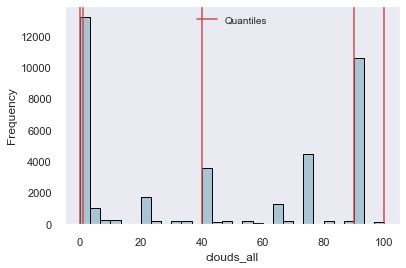

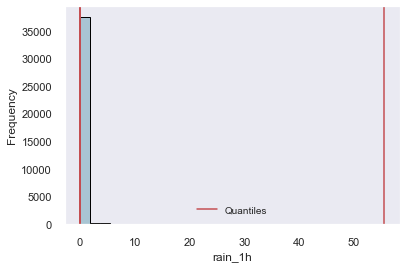

In [14]:
def quantile_dist(col, labels = ['Sub zero', 'Cold', 'Mild', 'Pleasant']):
    quantile_list = [0, .25, .5, .75, 1.]
    quantiles = df[col].quantile(quantile_list)

    fig, ax = plt.subplots()
    df[col].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
    for quantile in quantiles:
        qvl = plt.axvline(quantile, color='r')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    quantile_labels = labels
    col_label = col+'_label'
    df[col_label] = pd.qcut(df[col].rank(method='first'), q=quantile_list, labels=quantile_labels)

%matplotlib inline

numeric_features = ['temp', 'clouds_all', 'rain_1h']
i=0

bin_labels = [['Sub zero', 'Cold', 'Mild', 'Pleasant'], ['Zero', 'Low', 'Medium', 'High'], ['Zero', 'Low', 'Medium', 'High']]

for col in numeric_features:
    quantile_dist(col, labels = bin_labels[i])
    i=i+1
plt.show()

cols = [col for col in df if col != 'traffic_volume'] + ['traffic_volume']
df = df[cols]

Now we plot the relationships between traffic volume and numerical binned features.

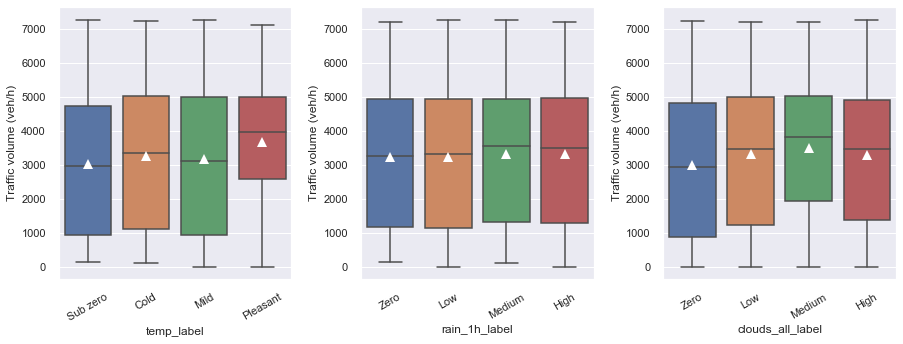

In [15]:
%matplotlib inline
figure, axes = plt.subplots(1, 3, figsize=(15,5))
plt.subplots_adjust(hspace = 0.5, wspace=0.30)

numeric_binned_features = ['temp_label', 'rain_1h_label', 'clouds_all_label']
i=0

for col in numeric_binned_features:
    b = i%3
    ax = sns.boxplot(y="traffic_volume_target", x=col, data=df, whis=np.inf, ax=axes[b], 
                     showmeans=True,
                    meanprops={"markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
    ax.set_xlabel(col)
    ax.set_ylabel('Traffic volume (veh/h)')
    i=i+1
plt.show()

We can draw the following insights from the above plots.
1. Pleasant weather with high temperatures (>290 K or 16.85 degreee celsius) seems to witness higher average hourly traffic volume. Sub zero temperature witnesses lower average hourly traffic volume.
2. 1 hour rainfall does not seem to suggest a strong feature that influences average hourly traffic volume. We might drop this feature.
3. High cloud cover seems to witness lower average hourly traffic volume. In low and medium cloud cover, average hourly traffic volume are observed to be higher. 

In [16]:
features = ['temp_label', 'clouds_all_label']
print('Updated feature set:', features)

Updated feature set: ['temp_label', 'clouds_all_label']


## Categorical features

There are four categorical features present in the dataset: weather_main, weather_description, date_time, holiday. Weather_main contains short description about weather.

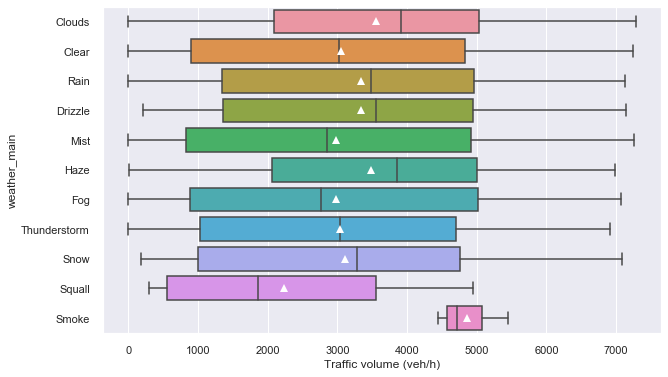

In [17]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="traffic_volume_target", y="weather_main", data=df, showmeans=True,
                meanprops={"markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"});
ax.set_xlabel('Traffic volume (veh/h)');

We can observe that mist, fog, thunderstorm, snow, and squall seem to present obstacle as in this weather we seem to observe lower average hourly traffic volume. Cloudy weather does not seem to deter traffic as we observe highest average hourly traffic volume. Interestingly, clear weather does not seem to be an important factor that affect traffic volumes. 

More information can be retrieved by looking at the weather_description field. We can observe low average hourly traffic volumes in snow, fog, thunderstorm.  These three features are also captured in the weather_main field. Thereofore, we will use weather_main field for our analysis.

In [18]:
# use this to remove duplicate names (e.g., sky is clear and Sky is clear)
df['weather_description'] = df['weather_description'].str.lower()

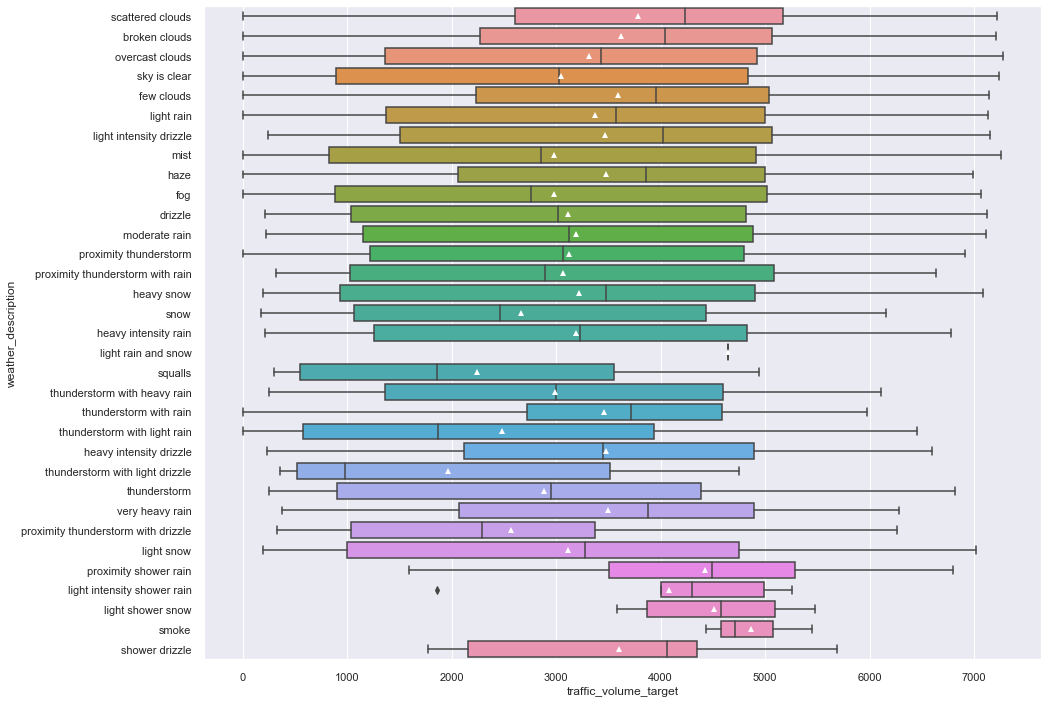

In [19]:
fig, ax = plt.subplots(figsize=(15,12))
ax = sns.boxplot(x="traffic_volume_target", y="weather_description", data=df, showmeans=True,
                meanprops={"markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"});

Now we will derive years, months, days of a week, and hours from the date time field. We use 2012 as our base year and convert the year field to an integer.

In [21]:
df['hour'] = df['date_time_target'].dt.hour
df['dow'] = df['date_time_target'].dt.day_name()
df['month'] = df['date_time_target'].dt.month
df['year'] = df['date_time_target'].dt.year - 2012 #Keep 2012 as the base year

# Rearrange columns so that the target field is lcoated at the end
cols = [col for col in df if col != 'traffic_volume_target'] + ['traffic_volume_target']
df = df[cols]

Next, we explore the effects of years, months, days of a week, and hours on the traffic volume using plots.

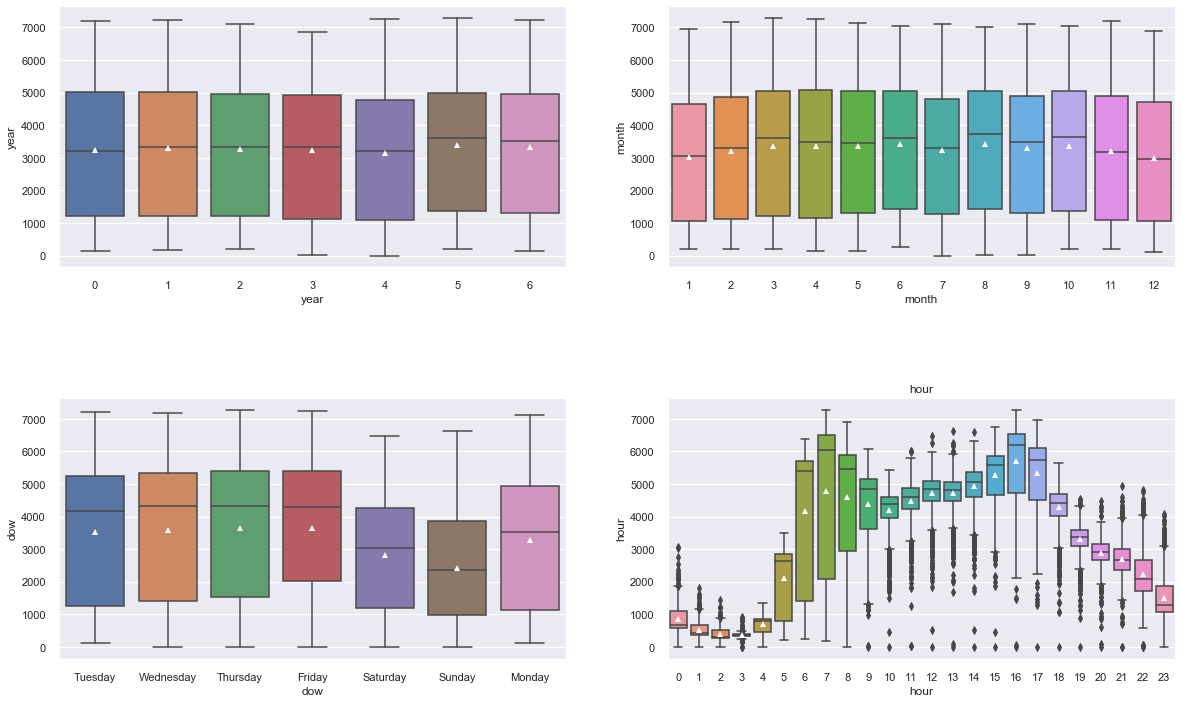

In [22]:
%matplotlib inline
figure, axes = plt.subplots(2, 2, figsize=(20,12))
plt.subplots_adjust(hspace = 0.5, wspace=0.20)

date_time_features = ['year', 'month', 'dow', 'hour']
i=0

for col in date_time_features:
    a = int(np.floor(i/2))
    b = i%2
    ax = sns.boxplot(x=col, y="traffic_volume_target", data=df, ax = axes[a][b] , showmeans=True,
                meanprops={"markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"});
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0);
    ax.set_ylabel(col)
    i=i+1
    plt.title(col)
plt.show()

We can derive the following insights.
1. Year seems to have no influence on the hourly traffic volume. Although higher traffic volumes are observed at recent years (e.g., 2017 and 2018).
2. Winter months and summer (July) observe lower hourly traffic volume.
3. Weekends typically are associated with lower hourly traffic volume.
4. There are two peaks observed if we look at the hourly trends. Hours of 7 AM and 3 PM are useful in predicting morning and evening peaks that are supposed to be located an hour after. Night hours (22:00 h to 4:00 h) observe lower hourly traffic volumes. On average, 6000 veh/h are observed during the evening peak hour.

Now, we will explore the effects of holidays.

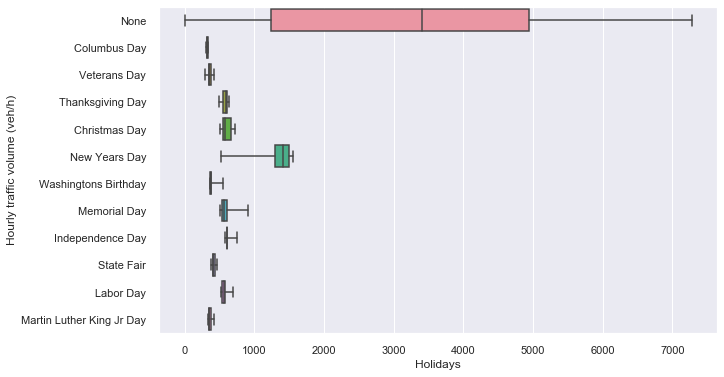

In [23]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(y="holiday", x="traffic_volume_target", data=df, whis=np.inf)
ax.set_xlabel('Holidays')
ax.set_ylabel('Hourly traffic volume (veh/h)');

Compared to a regular day, 1/4th traffic is observed during holidays. State fair, Martin Luther King Jr day, and Columbus day seem to witness lower hourly average traffic volumes. We can now combine holidays into two labels: MN State fair and US holidays. 

In [24]:
df['holiday'] = df['holiday'].apply(lambda x: 'Regular day' if x == 'None' else ('MN State fair' if x == 'State Fair' else 'US holiday'))
df['holiday'].value_counts()

Regular day      37909
US holiday          45
MN State fair        5
Name: holiday, dtype: int64

Now we create a new feature, day_type, that distinguishes among regular days of the week and holidays (state fair and US national holidays).

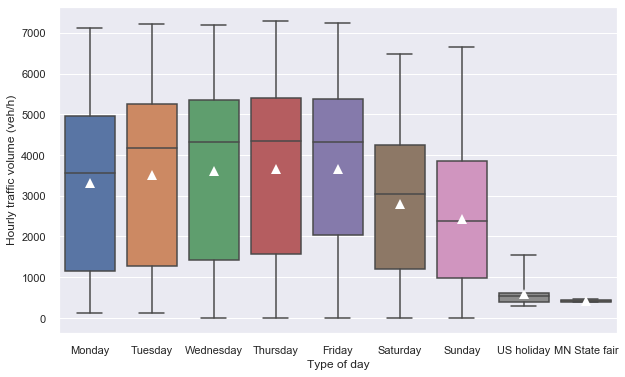

In [25]:
def day_type(row):
    if row['holiday'] == 'Regular day':
        return row['dow']
    else:
        return row['holiday']

df['day_type'] = df.apply(day_type, axis=1)

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday", "US holiday", "MN State fair"]

plt.figure(figsize=(10,6))
ax = sns.boxplot(x="day_type", y="traffic_volume_target", data=df, whis=np.inf, order = day_order, showmeans=True,
                meanprops={"markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"});
ax.set_xlabel('Type of day');
ax.set_ylabel('Hourly traffic volume (veh/h)');

We can observe that MN state fair witnesses least amount of hourly traffic volumes followed by US holidays and weekends. Among weekdays, Friday seems to witness higher traffic volumes of around 3500 veh/h.

In [26]:
features = ['temp_label', 'clouds_all_label', 'weather_main', 'hour', 'month',  'day_type', 'year']
print('Updated feature set:', features)

Updated feature set: ['temp_label', 'clouds_all_label', 'weather_main', 'hour', 'month', 'day_type', 'year']


# Experiments

In this part, we present our experimental setup. We describe feature set and perform model selection usign train-validation-test split.

We use year as a numeric feature to capture yearly trends and rest as the categorical features.

In [27]:
numeric_features = ['year', 'traffic_volume']
categorical_features = ['weather_main', 'hour', 'month',  'day_type', 'temp_label', 'clouds_all_label']
features = numeric_features + categorical_features

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)
print('NFeatures:', features)

Numeric features: ['year', 'traffic_volume']
Categorical features: ['weather_main', 'hour', 'month', 'day_type', 'temp_label', 'clouds_all_label']
NFeatures: ['year', 'traffic_volume', 'weather_main', 'hour', 'month', 'day_type', 'temp_label', 'clouds_all_label']


In this notebook, we have considered the following 4 models.
1. Linear Regression,
2. Ridge Regression,
3. Lasso Regression, and 
4. Multi-layer Perceptron Regressor.

We use a pipeline to perform the model selection. Our pipeline has several components.

1. One-hot encoding for categorical features
2. Standard scaler for numerical features
3. Model fir on the training dataset
4. Model performance on the validation dataset

We look at R2 score, mean absolute percentage error (MAPE), and mean absolute error (MAE) to evalaute the performance of models. 

The dataset is split into three: training (2012-2016 years), validation (2017 year) and test (2018 year). We use the training dataset for training models, validation dataset for model selection, and the testing dataset for assessing model performance on an unseen dataset.

In [28]:
from sklearn.model_selection import train_test_split

train_dataset = df[(df.year!=6) & (df.year!=5)]

val_dataset = df[df.year == 5]

test_dataest = df[df.year == 6]

X_train, y_train = train_dataset[features], train_dataset['traffic_volume_target']
X_val, y_val = val_dataset[features], val_dataset['traffic_volume_target']
X_test, y_test = test_dataest[features], test_dataest['traffic_volume_target']

print('Size of the training dataset:', X_train.shape[0])
print('Size of the validation dataset:', X_val.shape[0])
print('Size of the test dataset:', X_test.shape[0])

Size of the training dataset: 22746
Size of the validation dataset: 8692
Size of the test dataset: 6521


In [29]:
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, BayesianRidge, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, cross_validate

column_trans = ColumnTransformer(
    [('category', OneHotEncoder(handle_unknown = 'ignore'), categorical_features),
     ('numerical', StandardScaler(), numeric_features)])
models = []

models.append(('LR', LinearRegression()))
models.append(('RR', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(100, 100), random_state=42, max_iter=500, 
                                   learning_rate_init=0.01, early_stopping=True)))

results_r2 = []
results_rmse = []

names = []
print('Model', 'r2', 'MAPE', 'MAE')
for name, model in models:
    rf = Pipeline(steps=[('preprocessor', column_trans),
                      ('regression', model)])
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    msg = "%s %.4f %.4f %.4f" % (name, r2_score(y_val, y_pred), mean_absolute_percentage_error(y_val, y_pred),
                                mean_absolute_error(y_val, y_pred))
    print(msg)

Model r2 MAPE MAE
LR 0.9467 0.1567 315.3539
RR 0.9466 0.1579 315.9445
Lasso 0.9463 0.1565 317.8599
MLP 0.9832 0.0822 173.6589


Multi-layer Perceptron Regressor is selected as it achieves the best performance in terms of R2 score, MAPE, and MAE on the validation dataset.

# Results

In this section, we use the Multi-layer Perceptron Regressor to assess its performance on the unseen test dataset.

In [30]:
column_trans = ColumnTransformer(
    [('category', OneHotEncoder(handle_unknown = 'ignore'), categorical_features),
     ('numerical', StandardScaler(), numeric_features)])

models = []
# Two hidden layers with 100 units
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(100, 100), random_state=42, max_iter=500, 
                                   learning_rate_init=0.01, early_stopping=True)))

results_r2 = []
results_rmse = []

names = []
print('Model', 'r2', 'MAPE', 'MAE')
for name, model in models:
    rf = Pipeline(steps=[('preprocessor', column_trans),
                      ('regression', model)])
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    msg = "%s %.4f %.4f %.4f" % (name, r2_score(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred),
                                mean_absolute_error(y_test, y_pred))
    print(msg)

Model r2 MAPE MAE
MLP 0.9824 0.1071 188.4149


The Multi-layer Perceptron Regressor acheives the R2 score of 0.9824 as the model can explain 98.24% of the variance. The MAPE and MAE are observed to be 0.1071 and 188.4149, respectively. The very low value of MAPE suggests that the average absolute percent error for each hour is very low. These parameters are comparable to the validation performance. 

Let's plot at random 500 hours to assess how the model predicts on the test dataset. The model is able to precit peaks and lows quite successfully. 

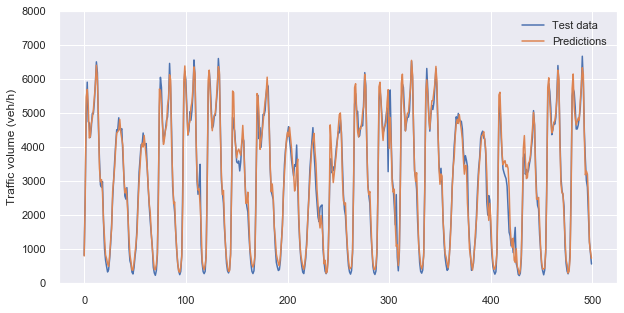

In [31]:
plt.figure(figsize = (10,5))
plt.plot(y_test.to_numpy()[100:600])
plt.plot(y_pred[100:600])
plt.legend(['Test data', 'Predictions']);
plt.ylabel('Traffic volume (veh/h)')
plt.ylim([0, 8000]);

Now, we will use feature importance to identify key features that the Multi-layer Perceptron Regressor uses to predict the next hour traffic volume. It seems that the traffic volume of the previous hour, hours of the day, and type of day are three most important features. 
1. Traffic volume is the strongest predictor as next hour traffic volumes do not seem to be entirely different than the current hour. 
2. Hours of day include peak and no-peak hour effects.
3. Type of day include weekdays, weekends, and holidays that are essenti

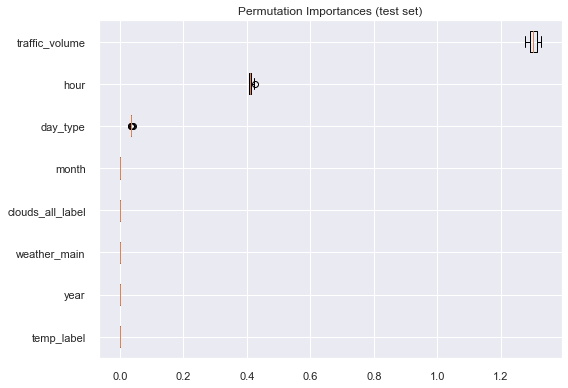

In [32]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8,5.5))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Conclusions

We have used I-94 hourly traffic dataset for short-term (hourly) traffic prediction. We demonstrate that the Multi-layer Perceptron Regressor can predict hourly traffic with a R2 scroe of 0.9824. The model achives this performance on an unseen dataset which also shows its forecasting capabilties. This model can capture peak and off-peak hour trends; therefore, it can be used in traffic management systems deployed as the Intelligent Transportation Systems.